In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join

import scmomat 

plt.rcParams["font.size"] = 10

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanx

## Step 1: Load dataset

In [2]:
# Path to the data directory
data_dir = "/home/sda1/yanxh/data/DOGMA"
# out_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main/output/pretrain/scmomat/dogma'

In [3]:
print('Reading `mtx` files...')
rna_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'RNA/rna_mat_count.mtx')).T)
adt_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'ADT/adt_mat_count.mtx')).T)
atac_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'ATAC/atac_mat_count.mtx')).T)

rna_names = pd.read_csv(join(data_dir, 'RNA/hvg_names.csv'))['VariableFeatures(data_ref)'].to_numpy()
adt_names = pd.read_csv(join(data_dir, 'ADT/adt_names.csv'))['VariableFeatures(data_ref)'].to_numpy()
atac_names = pd.read_csv(join(data_dir, 'ATAC/hvp_names.csv'))['VariableFeatures(data_ref)'].to_numpy()

cell_names = pd.read_csv(join(data_dir, 'cell_names.csv'))['x'].to_numpy()
meta_data = pd.read_csv(join(data_dir, 'metadata.csv'), index_col=0)
meta_data = meta_data[['stim', 'predicted.celltype.l1', 'predicted.celltype.l2']].copy()

rna_count_mat.shape, adt_count_mat.shape, atac_count_mat.shape

Reading `mtx` files...


((13763, 2000), (13763, 210), (13763, 50285))

In [4]:
train_idx = np.where((meta_data.stim=='Control').to_numpy())[0]
test_idx  = np.where((meta_data.stim=='Stim').to_numpy())[0]

train_idx.size, test_idx.size

(7624, 6139)

## down scale data

In [5]:
## taking highly variable peaks
hvp_idx = np.argsort(atac_count_mat[train_idx].sum(axis=0).A1)[-20000:]
hvp_names = atac_names[hvp_idx]

### format data

In [6]:
n_batches = 4

genes = rna_names
proteins = adt_names
peaks = hvp_names
feats_name = {"rna": genes, "adt": proteins, 'atac':peaks}

barcodes = [cell_names[train_idx], cell_names[test_idx], cell_names[test_idx], cell_names[test_idx]]
labels = [meta_data.loc[_, 'predicted.celltype.l1'].to_list() for _ in barcodes]
mods = [['multiome']*train_idx.size, ['rna']*test_idx.size, ['adt']*test_idx.size, ['atac']*test_idx.size]
batches = [['control']*train_idx.size, ['stim']*test_idx.size, ['stim']*test_idx.size, ['stim']*test_idx.size]

In [7]:
# READ IN THE COUNT MATRICES
# scRNA-seq of batches
counts_rna1 = rna_count_mat[train_idx]
counts_rna1 = scmomat.preprocess(counts_rna1.A, modality = "RNA", log = False)
counts_rna2 = rna_count_mat[test_idx]
counts_rna2 = scmomat.preprocess(counts_rna2.A, modality = "RNA", log = False)
counts_rnas = [counts_rna1, counts_rna2, None, None]

# adt of batches
counts_adt1 = adt_count_mat[train_idx]
counts_adt1 = scmomat.preprocess(counts_adt1.A, modality = "ADT")
counts_adt3 = adt_count_mat[test_idx]
counts_adt3 = scmomat.preprocess(counts_adt3.A, modality = "ADT")
counts_adts = [counts_adt1, None, counts_adt3, None]

# atac of batches
counts_atac1 = atac_count_mat[train_idx][:, hvp_idx]
counts_atac1 = scmomat.preprocess(counts_atac1.A, modality = "ATAC")
counts_atac4 = atac_count_mat[test_idx][:, hvp_idx]
counts_atac4 = scmomat.preprocess(counts_atac4.A, modality = "ATAC")
counts_atacs = [counts_atac1, None, None, counts_atac4]

In [8]:
# CREATE THE COUNTS OBJECT
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "adt": counts_adts, 'atac':counts_atacs}

## Step 2: training scMoMaT
The hyper-parameter includes `lamb` for weight lambda in the objective function, `K` for the number of latent dimensions. The default parameter (`lamb = 0.001`, `K = 30`) works for most of the real datasets.

Input sanity check...
Finished.
Epoch 1, Validating Loss: 348.0787
	 loss reconstruction: 0.34754
	 loss regularization: 0.54000
Epoch 1000, Validating Loss: 264.1106
	 loss reconstruction: 0.26409
	 loss regularization: 0.02419
Epoch 2000, Validating Loss: 262.1353
	 loss reconstruction: 0.26211
	 loss regularization: 0.02160
Epoch 3000, Validating Loss: 261.4296
	 loss reconstruction: 0.26141
	 loss regularization: 0.02176
Epoch 4000, Validating Loss: 261.0307
	 loss reconstruction: 0.26101
	 loss regularization: 0.01762
running time: 259.78142404556274


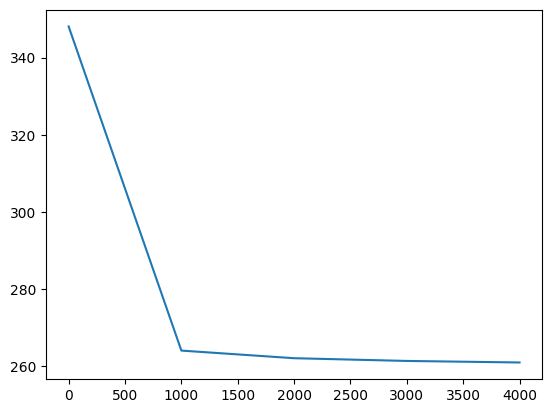

In [9]:
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 30
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Here we list other parameters in the function for illustration purpose, most of these parameters are set as default value.
# weight on regularization term, default value
lamb = 0.001 
# number of total iterations, default value
T = 4000
# print the result after each ``interval'' iterations, default value
interval = 1000
# batch size for each iteraction, default value
batch_size = 0.1
# learning rate, default value
lr = 1e-2
# random seed, default value
seed = 0
# running device, can be CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

# Plot loss function
x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

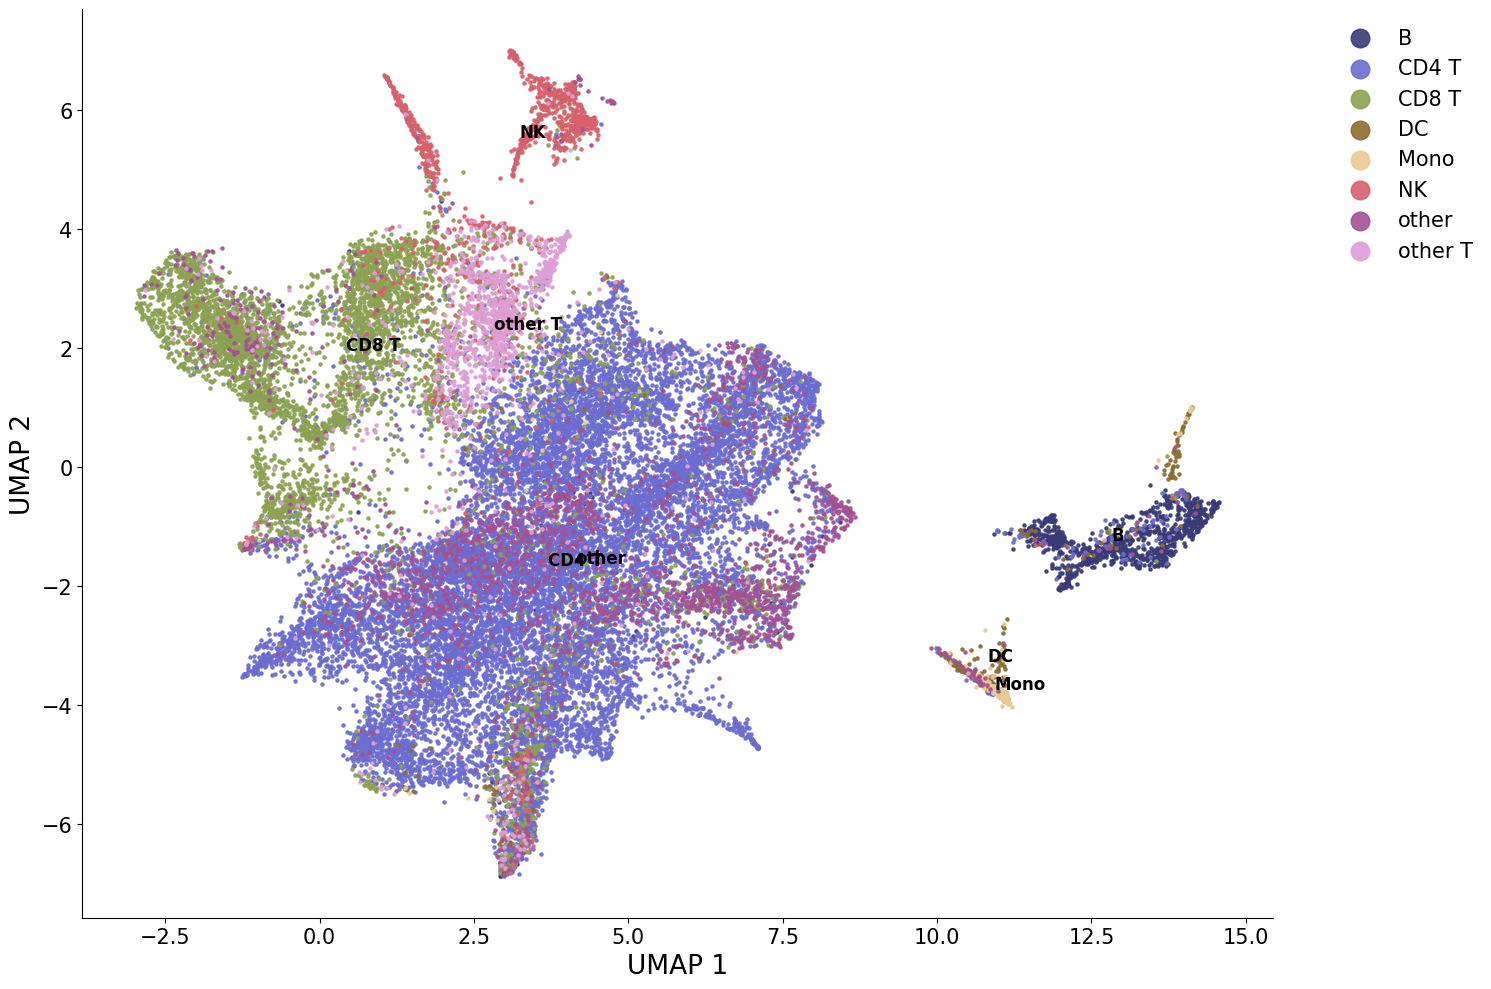

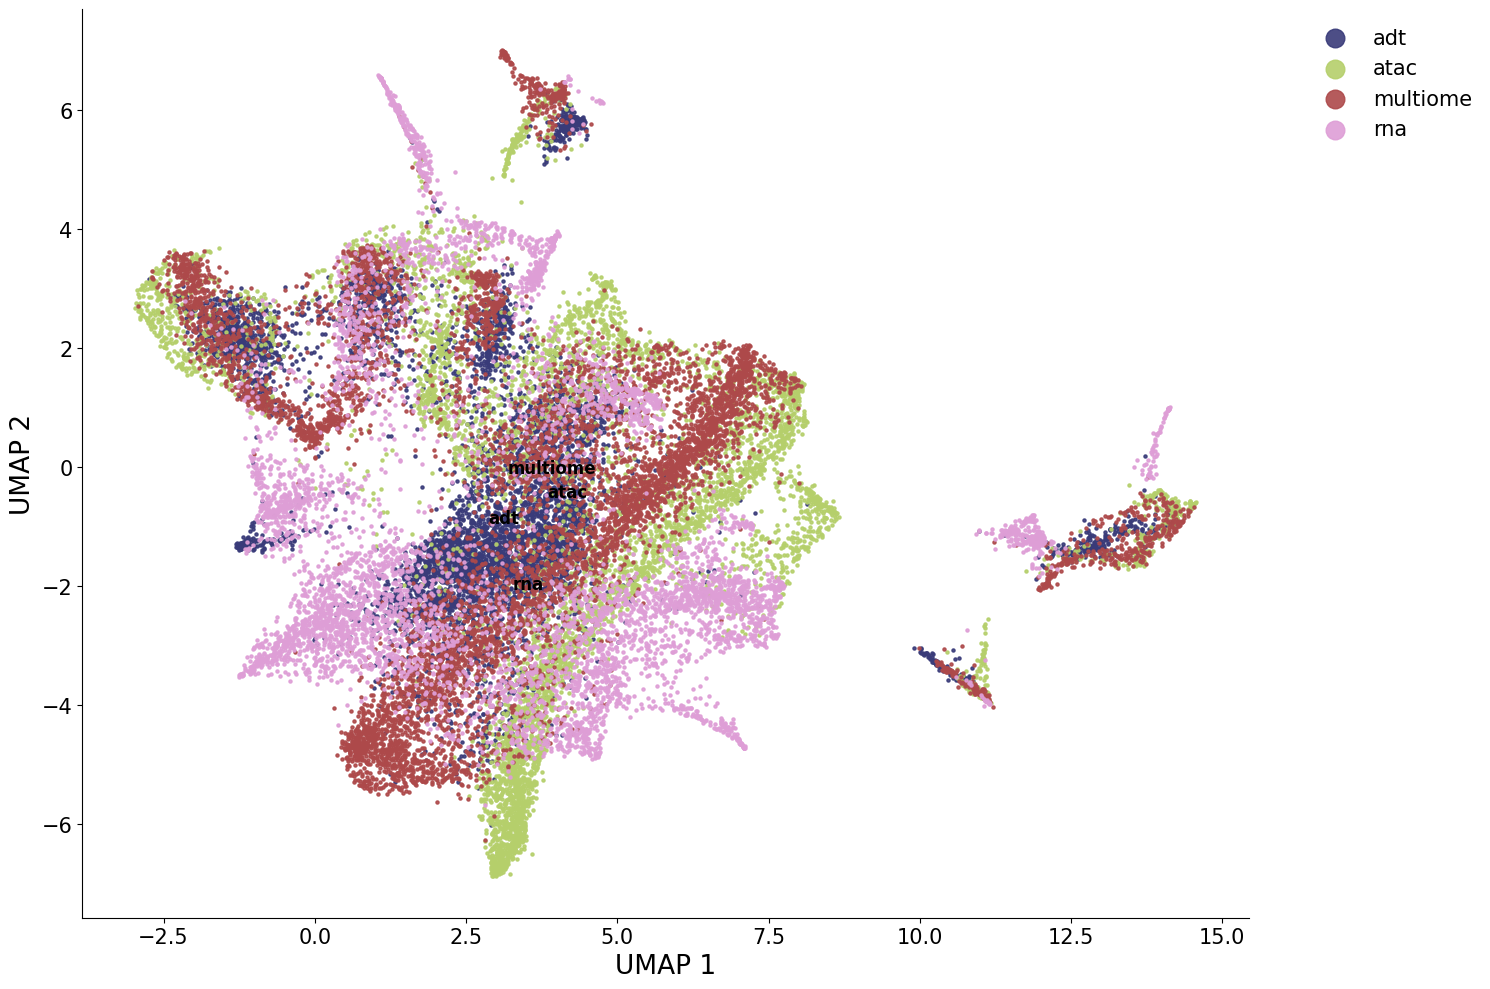

In [10]:
# read in the ground truth labels
# NOTE: Plot the result before post-processing
umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 
zs = model.extract_cell_factors()
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

scmomat.plot_latent(x_umap, annos = np.concatenate(labels), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)
scmomat.plot_latent(x_umap, annos = np.concatenate(mods), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)

## Step 3: Post-processing
The hyper-parameter includes `n_neighbors` and `r`. Use `r = None` unless the cell type composition is highly unmatched. In the unmatched case, `r` can be set between `0.5` and `1`, where a smaller values means lower batch correction. `n_neighbors` should be adjusted according to the total number of batches, usually `5-15` for each batch would be enough.

In [11]:
zs = model.extract_cell_factors()

# n_neighbors = 100
# r = None
# resolution = 0.9
# knn_indices, knn_dists = scmomat.calc_post_graph(zs, n_neighbors, njobs = 8, r = r)
# # labels_leiden = scmomat.leiden_cluster(X = None, knn_indices = knn_indices, knn_dists = knn_dists, resolution = resolution)
# x_umap = scmomat.calc_umap_embedding(
#     knn_indices = knn_indices, knn_dists = knn_dists, 
#     n_components = 2, n_neighbors = n_neighbors, min_dist = 0.20, random_state = 0)

# scmomat.plot_latent(x_umap, 
#                     annos=np.concatenate(mods),
#                     mode = "joint", save = None,\
#                       figsize = (10,7), axis_label = "UMAP", 
#                     markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

# scmomat.plot_latent(x_umap, 
#                     annos=np.concatenate(labels),
#                     mode = "joint", save = None,\
#                       figsize = (10,7), axis_label = "UMAP", 
#                     markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)



# Eval results

In [12]:
ad_mosaic = sc.AnnData(np.vstack(zs), obsm={"X_emb":np.vstack(zs)})
ad_mosaic.obs['batch'] = np.hstack(batches)
ad_mosaic.obs['mod']   = np.hstack(mods)
ad_mosaic.obs['cell_type'] = np.hstack(labels)
# ad_mosaic.obsm['X_umap'] = x_umap

# ad_mosaic.obsp['connectivities'] = scmomat.utils._compute_connectivities_umap(
#     knn_indices = knn_indices, knn_dists = knn_dists, 
#     n_neighbors = 15, set_op_mix_ratio=1.0, local_connectivity=1.0
# )

# ad_mosaic.uns['neighbors'] = {'connectivities_key':'connectivities'}

In [13]:
# import sys
# sys.path.insert(0, '.')

from evaluation import eval_mosaic, eval_specific_mod, eval_bridge, print_results, eval_asw, eval_lisi, eval_clustering
from evaluation import eval_bridge_above2

def get_umap(adata, use_rep='X_emb_shr'):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    return adata

### before harmony

In [14]:
# mosaic eval
r = eval_mosaic(ad_mosaic, label_key='cell_type', batch_keys=['mod'], use_lisi=True, use_rep='X_emb', use_neighbors=False)  # mod-lisi = batch_lisi

cell_type_LISI=0.95668
mod_LISI=0.26783
Compute neighbors using X_emb
GC=0.90726
NMI=0.40445
ARI=0.48603


In [15]:
# nmi, ari using nmi search
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb', use_neighbors=False,
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.40445010658122216, 0.48603076539200424)

In [16]:
ad_gex_test = sc.AnnData(zs[1], obsm={"X_emb":zs[1]})
ad_adt_test = sc.AnnData(zs[2], obsm={"X_emb":zs[2]})
ad_atac_test = sc.AnnData(zs[3], obsm={"X_emb":zs[3]})

ad_gex_test.obs['cell_type'] = labels[1]; ad_gex_test.obs['batch'] = batches[1]; ad_gex_test.uns['mod'] = 'gex'
ad_adt_test.obs['cell_type'] = labels[2]; ad_adt_test.obs['batch'] = batches[2]; ad_adt_test.uns['mod'] = 'adt'
ad_atac_test.obs['cell_type'] = labels[3]; ad_atac_test.obs['batch'] = batches[3]; ad_atac_test.uns['mod'] = 'atac'

r = eval_bridge_above2(
    [ad_gex_test, ad_adt_test, ad_atac_test],
    label_key='cell_type',
    batch_key='batch',
    mod_key='mod',
    use_rep='X_emb',
    use_acc=False
)

FOSCTTM: gex-adt=0.23985
FOSCTTM: gex-atac=0.31436
FOSCTTM: adt-atac=0.29204
FOSCTTM=0.28209
Matching score: gex-adt=0.00160
Matching score: gex-atac=0.00217
Matching score: adt-atac=0.00193
Match_score=0.00190


### after harmony

In [17]:
from preprocessing import harmony

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
ad_mosaic_df['batch'] = ad_mosaic.obs['mod'].to_numpy()
ad_mosaic.obsm['X_emb_harmony'] = harmony([ad_mosaic_df])[0]

# mosaic eval
r = eval_mosaic(ad_mosaic, label_key='cell_type', batch_keys=['mod'], 
                use_lisi=True, use_gc=False, use_rep='X_emb_harmony', use_nmi=False, use_neighbors=False)

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).
cell_type_LISI=0.94749
mod_LISI=0.53873


In [18]:
# nmi, ari using nmi search
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb_harmony', use_neighbors=False,
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.4187006573036558, 0.478579813192628)

In [20]:
n0, n1, n2, n3 = [len(_) for _ in zs]
z_har_gex_test = ad_mosaic.obsm['X_emb_harmony'][n0:(n0+n1)].copy()
z_har_adt_test = ad_mosaic.obsm['X_emb_harmony'][(n0+n1):(n0+n1+n2)].copy()
z_har_atac_test = ad_mosaic.obsm['X_emb_harmony'][-n3:].copy()

ad_gex_test = sc.AnnData(z_har_gex_test, obsm={"X_emb_harmony":z_har_gex_test})
ad_adt_test = sc.AnnData(z_har_adt_test, obsm={"X_emb_harmony":z_har_adt_test})
ad_atac_test = sc.AnnData(z_har_atac_test, obsm={"X_emb_harmony":z_har_atac_test})

ad_gex_test.obs['cell_type'] = labels[1]; ad_gex_test.obs['batch'] = batches[1]; ad_gex_test.uns['mod'] = 'gex'
ad_adt_test.obs['cell_type'] = labels[2]; ad_adt_test.obs['batch'] = batches[2]; ad_adt_test.uns['mod'] = 'adt'
ad_atac_test.obs['cell_type'] = labels[3]; ad_atac_test.obs['batch'] = batches[3]; ad_atac_test.uns['mod'] = 'atac'

r = eval_bridge_above2(
    [ad_gex_test, ad_adt_test, ad_atac_test],
    label_key='cell_type',
    batch_key='batch',
    mod_key='mod',
    use_rep='X_emb_harmony',
    use_acc=False
)

FOSCTTM: gex-adt=0.21783
FOSCTTM: gex-atac=0.31032
FOSCTTM: adt-atac=0.29465
FOSCTTM=0.27427
Matching score: gex-adt=0.00295
Matching score: gex-atac=0.00198
Matching score: adt-atac=0.00170
Match_score=0.00221


# Vis

In [21]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [22]:
ad_mosaic.obs['mod'].unique()

['multiome', 'rna', 'adt', 'atac']
Categories (4, object): ['adt', 'atac', 'multiome', 'rna']

In [23]:
modD = {'atac':'atac', 'multiome':'multiome', 'rna':'gex', 'adt':'adt'}
ad_mosaic.obs['mod2'] = [modD[_] for _ in ad_mosaic.obs['mod']]
# ad_mosaic.obs['mod-batch2'] = ad_mosaic.obs['mod2'].astype('str') + '-' + ad_mosaic.obs.batch.astype('str')

In [24]:
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb', add_key='umap_be')
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb_harmony', add_key='umap_af')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


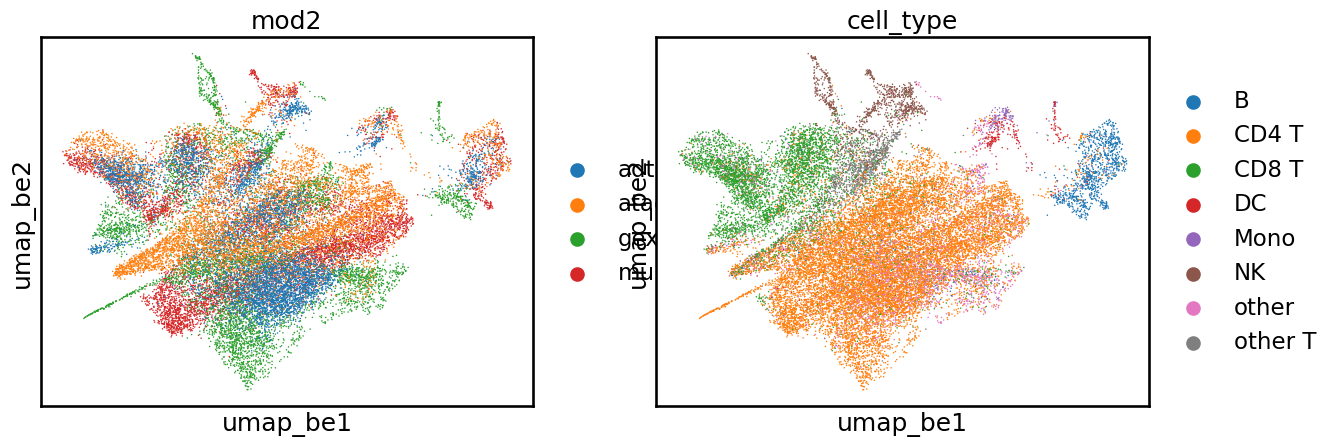

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


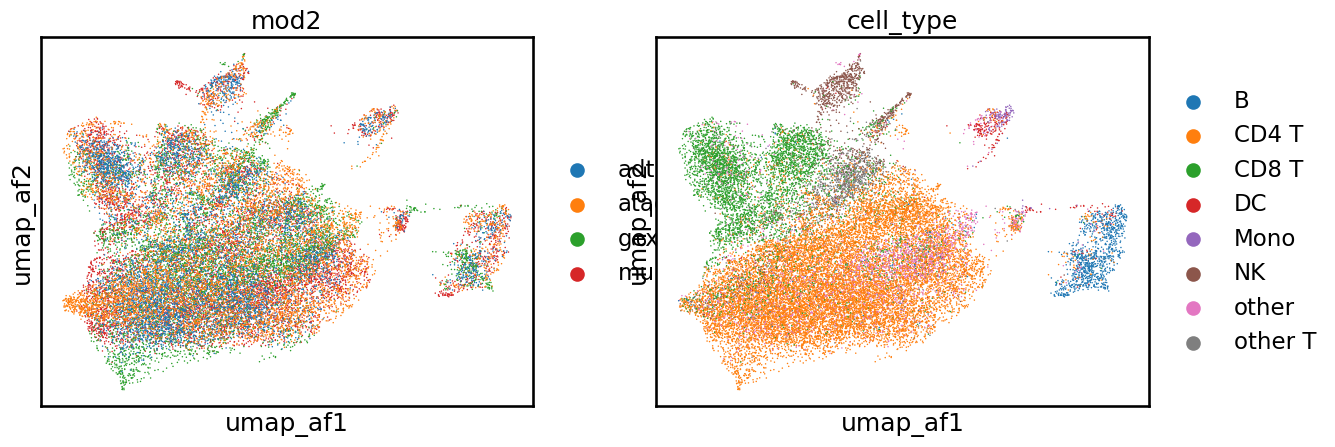

In [26]:
sc.pl.embedding(ad_mosaic, basis='umap_be',  color=['mod2', 'cell_type'])
sc.pl.embedding(ad_mosaic, basis='umap_af',  color=['mod2', 'cell_type'])

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages

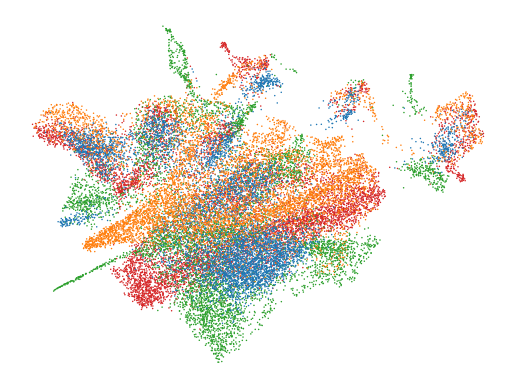

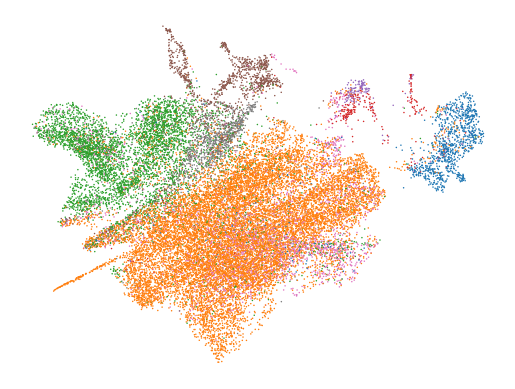

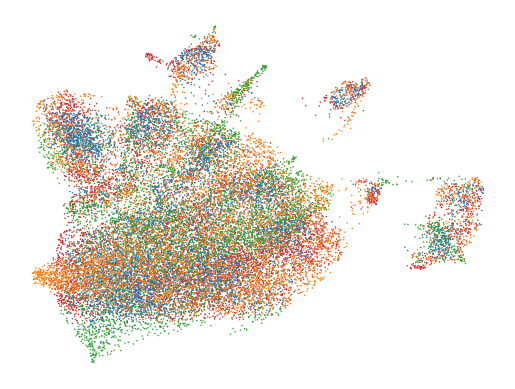

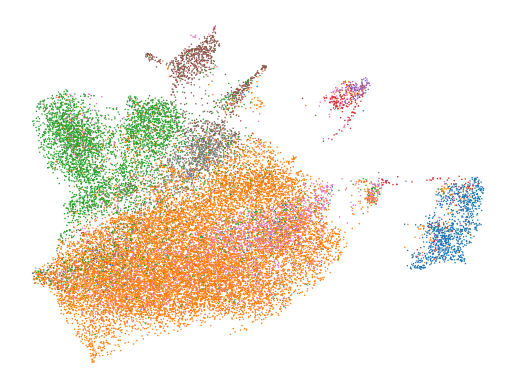

In [27]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

save_umap(ad_mosaic, 'umap_be', ['mod2', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec2/umap', 
          prefix_name='scMoMaT_case2_dogma')

save_umap(ad_mosaic, 'umap_af', ['mod2', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec2/umap', 
          prefix_name='scMoMaT-harmony_case2_dogma')

In [28]:
np.save(join(umap_save_dir, 'scMoMaT_case2_dogma_umap.npy'), ad_mosaic.obsm['umap_be'])
np.save(join(umap_save_dir, 'scMoMaT-harmony_case2_dogma_umap.npy'), ad_mosaic.obsm['umap_af'])